# On the Importance of Good Indices

The beginning of a new school year is always a busy time.  But these last three years I have found myself holding my breath and watching Google’s real time analytics with more than a bit of nervousness.  The charts below should give you a good idea why.

I'm using the newly renamed Jupyter notebooks feature to show off some data from the interactivepython.org website over the past few years, as well as to get more practice with Pandas and some of its graphing capabilities.  


In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sbn
sbn.set()


This first chart shows the number of daily sessions, starting from when we launched interactivepython.org in June of 2012 until just this last week.  Although the labels on the x axis are two close together to read you get the idea.  We see stead growth each semester with lulls in the summer.  The beginnings of the traffic increase fo this fall are just starting to show.  It looks like we are going to see significant growth over last spring once again this fall.

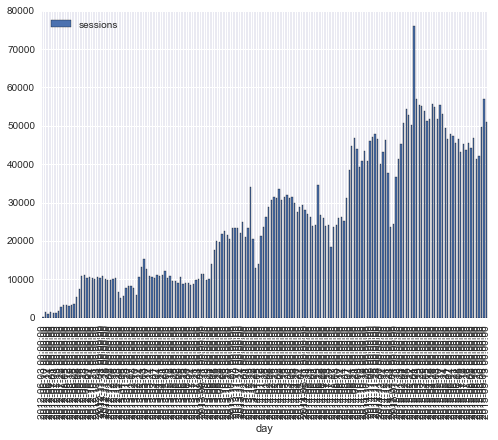

In [53]:
df = pd.read_csv('Data/Analytics interactivepython.org Audience Overview 20120601-20150911.csv')
df['day'] = pd.to_datetime(df['day'], coerce=True)
df.index = df.pop('day')
df.resample('W',how='sum').plot(kind='bar')


## Organic growth can lead to bad design

Because Runestone Interactive is both a research project as well as a production site for many schools around the world, we haven't always been the most careful about coordinating new features, or thinking about scalability.  Many features are conceived of and implemented for small classes done in isolation.  But when you combine them and serve them on a site growing like interactivepython.org this can lead to problems.

Specifically, over the last few days I have figured out that every page that is loaded makes the api calls to updatelastpage as well as getCompletionStatus.  These two separate API calls may be handled by different processes on the server.  They both update and read the same two tables...  This is a classic deadlock scenario, and although we haven't really had too many problems with that in the past, I started noticing deadlock messages last spring.  On Thursday of this last week it got really bad, and it finally hit me why.

The following graph shows the average time for the updatelastpage API call averaged over a month starting back in February 2014 when I started to collect daily data about API calls.  February 2014 corresponds to the last crisis in scalability :-)


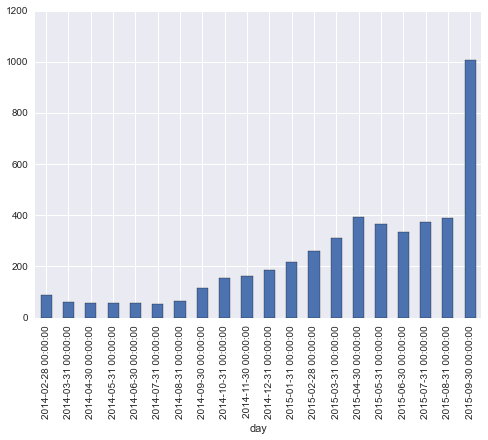

In [55]:
uplp = pd.read_table('Data/updatelastpage',sep='\s+',header=None)
uplp.columns = ['day','useless','count','avgtime','maxtime']
uplp.day = pd.to_datetime(uplp.day,coerce=True)
uplp.index = uplp.pop('day')
uplp.avgtime.resample('M',how='mean').plot(kind='bar')

Similarly, we can see how badly the getCompletionStatus is performing of late.

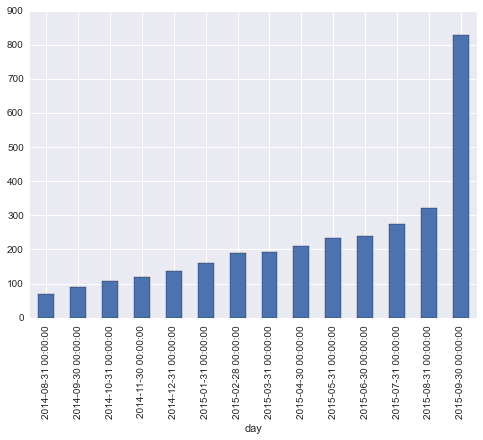

In [56]:
cs = pd.read_table('Data/completionStatus',sep='\s+',header=None)
cs.columns = ['day','useless','count','avgtime','maxtime']
cs.day = pd.to_datetime(cs.day,coerce=True)
cs.index = cs.pop('day')
cs.avgtime.resample('M',how='mean').plot(kind='bar')

The reason that performance is getting worse and worse, and that deadlocks are happening more frequently is due to the lack of indices on key tables in my database.  Small tables without indices perform just fine, but some of thse key tables now have over 11 million rows in them.  scanning them from front to back to search for a single user begins to take time!

I've added indices to these key tables over the last 24 hours and I am alredy seeing that the performance of both updatelastpage and getCompletionStatus is returning to about the same levels as March of 2014!  This is good news for everyone.


## CloudFlare to distribute the load

In addition to adding the indices, this weekend, I've also subscribed to the CloudFlare Content Distribution Network.  This will also have a dramatic impact on the load on my server as all of the static html, css, and javscript files can now be cached and served out of CloudFlares network.  This should be particularly good news to all of the folks in India who represent the second largest country using the Runestone tools, but wh